Image classification from scratch
Author: fchollet
Date created: 2020/04/27
Last modified: 2020/04/28
Description: Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

Introduction
This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.

Setup


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

TPU 활용

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError("GPU device not found!!")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Load the data: the Cats vs Dogs dataset
Raw data download


In [ ]:
!rm -rf ./PetImages/*
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   199M      0  0:00:03  0:00:03 --:--:--  199M
 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [ ]:
!ls PetImages

Cat  Dog


Filter out corrupted images
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.


In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


Generate a Dataset

In [ ]:
image_size = (180, 180)
# print(image_size)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Visualize the data
Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".


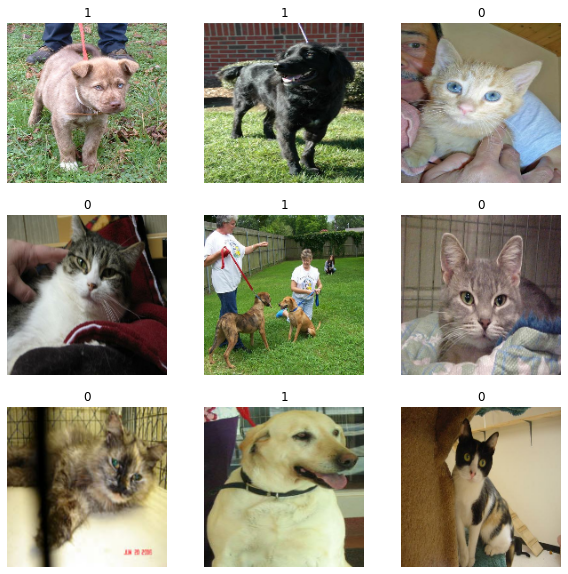

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Using image data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

data_augmentation 데이터 세트의 첫 번째 이미지에 반복적으로 적용 하여 증강 샘플의 모양을 시각화 해 보겠습니다 .

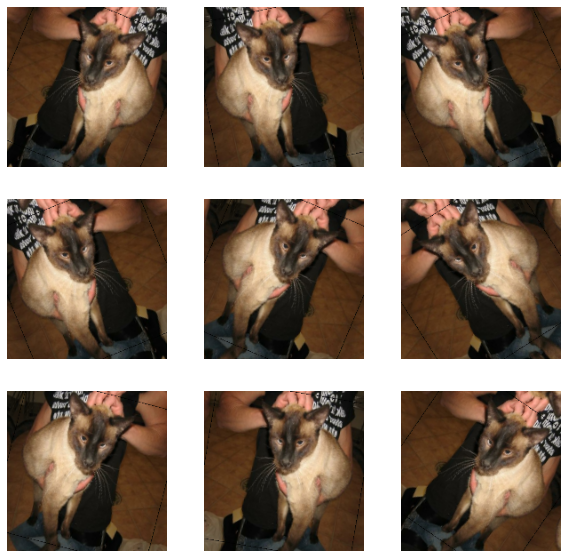

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Configure the dataset for performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

Note that:

We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.

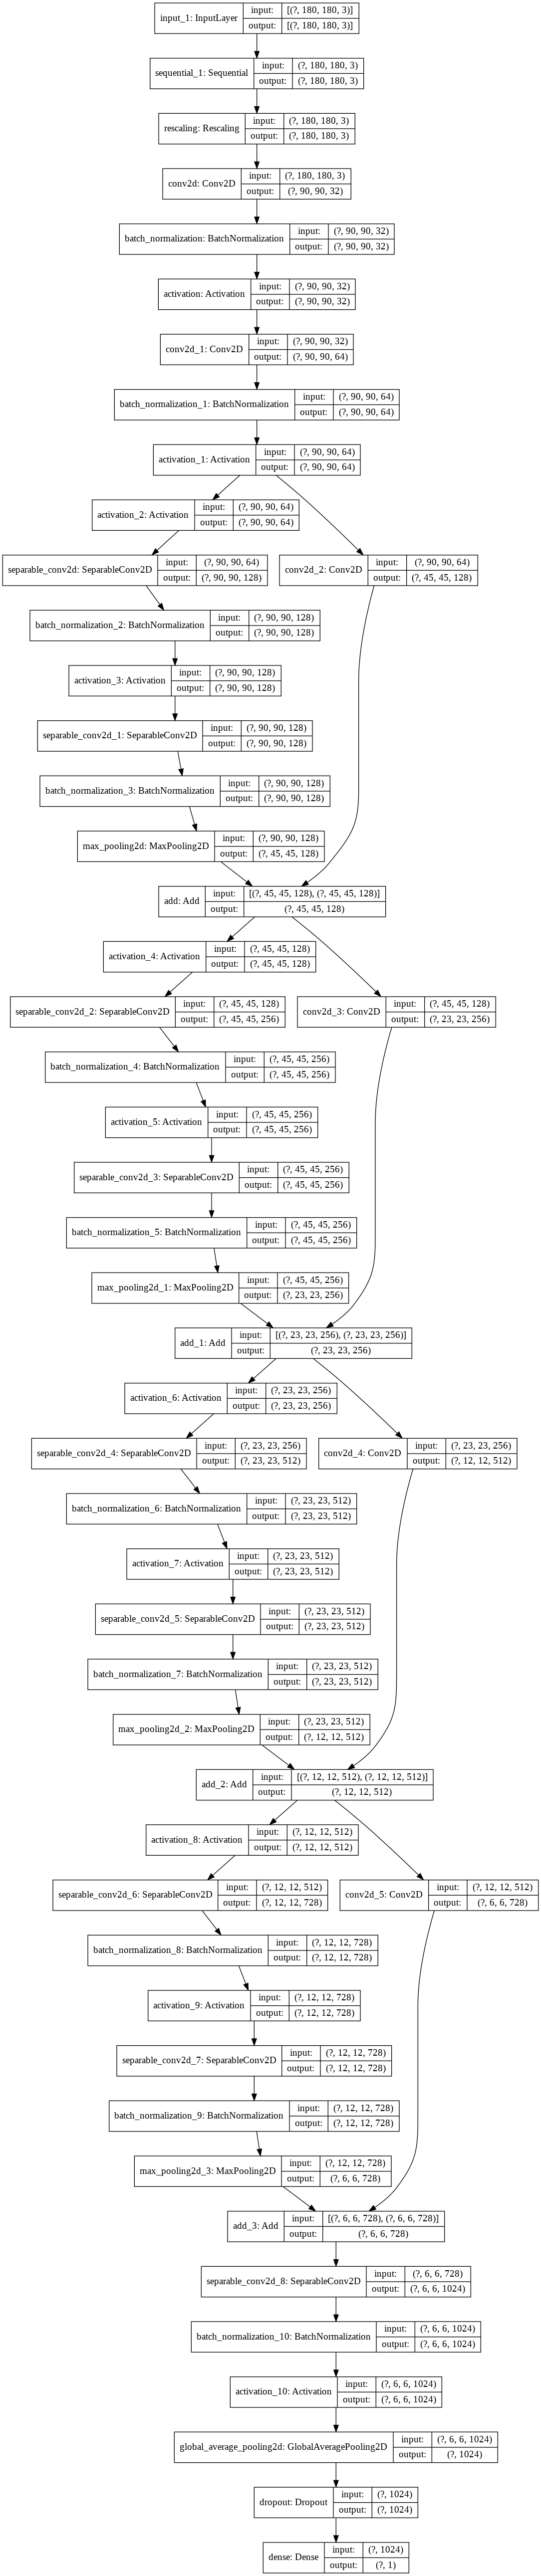

In [ ]:
def make_model(input_shape, num_classes):    
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

Train the model

In [ ]:
start = time.clock()
print(start)

epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

elapsed = (time.clock() - start)
print(elapsed)

17.299281
Epoch 1/5
586/586 [==============================] - 279s 477ms/step - loss: 0.6214 - accuracy: 0.6659 - val_loss: 0.8899 - val_accuracy: 0.5378
Epoch 2/5
489/586 [========================>.....] - ETA: 43s - loss: 0.4756 - accuracy: 0.7731

Run inference on new data
Note that data augmentation and dropout are inactive at inference time.

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

In [ ]:
!nvidia-smi
